In [1]:
from music21 import converter, instrument, note, chord, midi
import glob

import pandas as pd
import numpy as np
from numpy import newaxis

import random
import itertools

import os
from os import listdir
from os.path import isfile
import math

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec

import datetime
from tqdm import *
from datetime import *

import keras
from keras.applications import *
import lightgbm as lgbm
import os
from scipy import ndimage
from scipy import misc
from scipy import signal
import cv2
plt.ion()
plt.show()

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Lambda, Layer,Flatten,TimeDistributed, BatchNormalization, GlobalMaxPooling1D
from keras.layers import Conv2D,Conv1D, MaxPooling1D, MaxPooling2D,UpSampling2D, concatenate, Dropout,Conv2DTranspose, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import metrics
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from music21 import instrument, note, stream, chord
import shutil
import collections
from collections import *
from keras import optimizers
import tensorflow as tf
from IPython.display import clear_output
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

from sklearn.utils import class_weight
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from os.path import isfile, join
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from skimage import morphology
from keras.utils import np_utils

from skimage import filters
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from music21 import corpus
from keras.layers import Concatenate, TimeDistributed

Using TensorFlow backend.


## Utils

In [130]:
from IPython.display import clear_output
from scipy.stats import entropy

def subsongStats(subsong):
    vs = np.argmax(subsong, axis=1)
    e = entropy([list(vs).count(x) for x in set(vs)]) # note entropy

    seq = []
    last = vs[0]
    count = 0
    for i in range(len(vs)):
        if last != vs[i]:
            seq.append(count)
            last = vs[i]
            count = 1
        else:
            count = count + 1
    
    seq.append(count)
    if len(seq) != 0:
        m = np.median(seq)
        if (len(seq) == 0):
            print(vs, seq, e, m)
        r = seq.count(1)/len(seq)
    else:
        m = 0
        r = 0
    
    return vs, e, m, r


def predictOneBitstream(seed, threshold=0.99, length=128):
    inp = seed
    for i in range(length):
        p = model.predict(inp[:,-lookback:,:])
        p = cleanpred(p[0, -1])
        inp = np.concatenate([inp,p[newaxis,newaxis,:]], axis=1)

    outp = inp[:,lookback:,:] # remove the seed
    return outp

def predictOneStream(seed, threshold=0.99):
    outp =predictOneBitstream(seed, threshold)

#     pp = predictOneBitstream(nn_inout2[i:i+1,:,:])
    print(outp.shape)
    v, e, m, p = subsongStats(outp[0]) 
    print(e,m,p)    
    
    
    output_notes = []
    s = stream.Stream()
    for i in range(len(outp[0])):
        n = predbitfieldtonote(outp[0,i],threshold=threshold)
        s.append(n)
    return s

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        self.e = []
        self.m = []
        self.p = []
        
    def on_train_begin(self, logs={}):
        ;
#         self.initVars()

    def on_epoch_end(self, epoch, logs={}):
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.i = self.i+1
        
        if self.i%5 != 0:
            return
        self.evaluateRandomSample()
        clear_output(wait=True)
        plt.figure(figsize=(12,12))
        ax = plt.subplot(221)
        self.plotLosses(ax)
        ax = plt.subplot(222)
        ax.plot(self.e)
        plt.title('entropy of note distribution')
        ax = plt.subplot(223)
        plt.title('median of repetition length')
        ax.plot(self.m)
        ax = plt.subplot(224)
        plt.title('percentage of repetition 1')
        ax.plot(self.p)
        plt.show()

        
    def evaluateRandomSample(self):
        i = random.randint(1, nn_inout2.shape[0])
        _, e, m, p = subsongStats(predictOneBitstream(nn_inout2[i:i+1,:,:])[0]) 
        self.e.append(e)
        self.m.append(m)
        self.p.append(p)
    
    def plotLosses(self, ax):
        plt.plot(np.arange(len(self.losses)), self.losses, label="train loss")
        plt.plot(np.arange(len(self.val_losses)), self.val_losses, label="val loss")
        # ax.set_yscale("log", nonposy='clip')
        plt.legend()
        
basicLossPlot = PlotLosses()

In [4]:
def printChord(c):
    print([x.nameWithOctave for x in c.pitches])
    print('PitchedCommonName: %s, root %s, intervalVector %s, normalOrder % ' % 
          (c.pitchedCommonName, c.root(), c.intervalVector, c.normalOrder))
    c.show()
    
def printNote(f):
    
    if f.name == 'rest':
        st = f.name
    else:
        st = f.name + str(f.step) + ' ' + str(f.octave) + ' ' +  str(f.pitch.french) + ' ' + str(f.pitch) + ' ' + str(f.pitch.frequency)
        if f.pitch.accidental:
            st = st + ' ' + f.pitch.accidental.name + ' -extra semi-tones:' + f.pitch.accidental.alter
#     print(st)
    f.addLyric(st)
    return f.show()

def printPitch(p):
    print(p, p.nameWithOctave, p.french, p.octave, p.frequency)
    if p.accidental:
        print(p.accidental, p.accidental.name, '-extra semi-tones: ',p.accidental.alter)

In [5]:
def readSong(s, maxtracks = -1, chordify = False, gatherRests=True, qlMult=4, qlMin=1, qlMax=16):
    # maxtracks=-1 returns 1 track with all elements combined one after the other, otherwise returns top X tracks
    # chordify toggles putting all parts together
    # gatherRests combines all rests into 1 (no more than 1 contiguous rest)
    # qlMult multiplies quarterLengths of notes/rests by that factor
    # qlMin/qlMax restricts note length
    
#     notes = np.zeros((0,n_vocab+(1+qlMax-qlMin)))
    notes = []
    
    if chordify == False:
        parts = s.parts
    else:
        parts = [s.chordify()]
    
    lastwasrest = False
    for p in parts:
        for element in p.recurse().notesAndRests:
            duration = int(element.duration.quarterLength *qlMult)
            duration = min(qlMax,max(qlMin,duration)) # don't want longer than whole or shorter than 16th
            ch = ''
            newnote = np.zeros(n_vocab+n_duration)
            
            if isinstance(element, note.Rest):
                nn = 0
                if lastwasrest == True and gatherRests == True:
                    continue # no need for multiple rests in this scenario
                lastwasrest = True
            elif isinstance(element, note.Note):
                lastwasrest = False
                nn = int(element.pitch.midi)+0
                newnote[nn] = 1
            elif isinstance(element, chord.Chord):
                lastwasrest = False
                for xxx in element.pitches:
                    newnote[xxx.midi] = 1

            newnote[n_vocab+int(duration)-1] = 1

            notes.append(newnote)
#             notes = np.concatenate([notes, newnote[newaxis,:]], axis=0)
            
    return np.stack(notes)

In [6]:
sequence_length = 100
n_vocab = 128
n_duration = 16
lookback = 32

In [110]:
from IPython.core.display import HTML, display
def cleanpred(pred, threshold=0.8):
    t = np.max(pred[:n_vocab])*threshold
    du = np.argmax(pred[n_vocab:])
    
#     print(np.where(pred[:n_vocab] > t))
    p2 = np.zeros(pred.shape)
    p2[np.where(pred[:n_vocab] > t)] = 1
    p2[n_vocab+du] = 1
    return p2

def predbitfieldtonote(pred, threshold=0.8):
    t = np.max(pred[:n_vocab])*threshold
    du = np.argmax(pred[n_vocab:])
    if np.argmax(pred)==0:
        n = note.Rest()
        n.duration.quarterLength = (du+1)/4
    else:
        nns = []
        for pp in np.where(pred[:n_vocab] > t)[0]:
            nn = note.Note()
            nn.pitch.midi = pp
            nns.append(nn)
        n = chord.Chord(nns)
        n.duration.quarterLength = (du+1)/4
    return n

def predtostream(pred):
    s = stream.Stream()
    for i in range(len(pred)):
        n = predbitfieldtonote(pred[i])
        s.append(n)
    return s


def writePrediction(inp, lookback=lookback, instr = None):
    outp = inp[:,lookback:,:] # remove the seed

    output_notes = []
    s = stream.Stream()
    for i in range(len(outp[0])):
        n = predbitfieldtonote(outp[0,i],threshold=thresh)
        s.append(n)
    filename = 'output/test_output' + datetime.now().strftime("%Y%m%d%H%M%S") + '.mid'
    print('writing prediction size %s to file %s ' % (outp.shape, filename))
    if(instrument is not None) :
#         s.insert(0, instrument.Organ())
        s.insert(0, instr)
    
    s.write('midi', fp=filename)
    display(HTML('<a href="' + filename + '" target="_" > bla</a>'))


## Read from corpus

In [22]:
if os.path.isfile('data/bachNoCordify1.npy'):
    nn_inout = np.load('data/bachNoCordify1.npy')
else:
    songs = []
    for i in tqdm(corpus.getComposer('bach', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = False, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
    nn_inout = np.vstack(songs)
    np.save('data/bachNoCordify1.npy', nn_inout)
    
nn_inout.shape

(670716, 144)

In [121]:
if os.path.isfile('data/bachCordify1.npy'):
    nn_inout = np.load('data/bachCordify1.npy')
else:
    songs = []
    for i in tqdm(corpus.getComposer('bach', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = True, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
    nn_inout = np.vstack(songs)
    np.save('data/bachCordify1.npy', nn_inout)
    
nn_inout.shape

(41985, 144)

In [18]:
if os.path.isfile('data/beethovenNoCordify1.npy'):
    nn_inout = np.load('data/beethovenNoCordify1.npy')
else:
    songs = []
    for i in tqdm(corpus.getComposer('beethoven', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = False, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
    nn_inout = np.vstack(songs)
    np.save('data/beethovenNoCordify1.npy', nn_inout)
    
nn_inout.shape

(721264, 144)

In [17]:
if os.path.isfile('data/beethovenCordify1.npy'):
    nn_inout = np.load('data/beethovenCordify1.npy')
else:
    songs = []
    for i in tqdm(corpus.getComposer('beethoven', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = True, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
    nn_inout = np.vstack(songs)
    np.save('data/beethovenCordify1.npy', nn_inout)
    
nn_inout.shape

  0%|          | 0/22 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
#palestrina

if os.path.isfile('data/2c.npy'):
    nn_inout = np.load('data/2c.npy')
else:
    songs = []
    for i in tqdm(corpus.getComposer('palestrina', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = False, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
        
    for i in tqdm(corpus.getComposer('bach', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = False, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
        

    nn_inout = np.vstack(songs)
    np.save('data/2c.npy', nn_inout)
    
nn_inout.shape

(670716, 144)

In [45]:

if os.path.isfile('data/4cCordify.npy'):
    nn_inout = np.load('data/4cCordify.npy')
else:
    songs = []
    for i in tqdm(corpus.getComposer('verdi', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = True, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
        
    for i in tqdm(corpus.getComposer('bach', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = True, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
        
    for i in tqdm(corpus.getComposer('mozart', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = True, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
        
    for i in tqdm(corpus.getComposer('beethoven', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = True, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
    nn_inout = np.vstack(songs)
    np.save('data/4cCordify.npy', nn_inout)
    
nn_inout.shape

(157952, 144)

In [27]:

if os.path.isfile('data/4c.npy'):
    nn_inout = np.load('data/4c.npy')
else:
    songs = []
    for i in tqdm(corpus.getComposer('verdi', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = False, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
        
    for i in tqdm(corpus.getComposer('bach', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = False, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
        
    for i in tqdm(corpus.getComposer('mozart', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = False, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
        
    for i in tqdm(corpus.getComposer('beethoven', 'mxl')):
        s = corpus.parse(i)
        songs.append(readSong(s, maxtracks = -1, chordify = False, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
    nn_inout = np.vstack(songs)
    np.save('data/4c.npy', nn_inout)
    
nn_inout.shape

(1501284, 144)

In [ ]:
# folderName = "data/*.mid"
folderName = "data/clean_midi/*/*.mid"
# fileName = 'data/cleanData.npy'
# fileName = 'data/cleanData1000000.npy'
fileName = 'data/cleanData5000000.npy'
if os.path.isfile(fileName):
    nn_inout = np.load(fileName)
else:
    songs = []
    for file in tqdm(glob.glob(folderName)[:300]):
        try:
            midiP = converter.parse(file)
            songs.append(readSong(midiP, maxtracks = -1, chordify = False, gatherRests=False, qlMult=4, qlMin=1, qlMax=16))
        except Exception:
            pass
    nn_inout = np.vstack(songs)
    np.save(fileName, nn_inout)
nn_inout.shape    

## Conv+spotify

In [74]:
inp = Input(shape=(lookback,nn_inout.shape[1],))
l1 = Conv1D(128,8, strides=1, activation='relu', padding='same')(inp)
l1 = Dropout(0.3)(l1)

# l1 = Conv1D(128,2, strides=1, activation='relu', padding='same')(l1)
# l1 = Dropout(0.4)(l1)
x= concatenate([l1,inp])
x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.3)(x)

x = LSTM(256)(x)
x = Dropout(0.3)(x)
x = Dense(nn_inout.shape[1])(x)
a1 = Activation('sigmoid')(Lambda(lambda z : z[:,:n_vocab])(x)) # notes
a2 = Activation('softmax')(Lambda(lambda z : z[:,n_vocab:])(x)) # duration
x= concatenate([a1,a2])
model = Model(inputs=inp, outputs=x)

# learning_rate = 0.1
# sgd = SGD(lr=learning_rate)

# model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
# model.compile(loss='binary_crossentropy', optimizer=sgd)
# model.compile(loss='mean_squared_error', optimizer='rmsprop')

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_24 (InputLayer)            (None, 32, 144)       0                                            
____________________________________________________________________________________________________
conv1d_38 (Conv1D)               (None, 32, 128)       147584      input_24[0][0]                   
____________________________________________________________________________________________________
dropout_74 (Dropout)             (None, 32, 128)       0           conv1d_38[0][0]                  
____________________________________________________________________________________________________
concatenate_27 (Concatenate)     (None, 32, 272)       0           dropout_74[0][0]                 
                                                                   input_24[0][0]          

In [119]:
inp = Input(shape=(lookback,nn_inout.shape[1],))
x = Conv1D(144,10, strides=1, activation='relu')(inp)
# x = MaxPooling1D(strides=2)(x)
# x = MaxPooling1D(strides=1)(x)
# x = MaxPooling1D(strides=1)(x)
# x = MaxPooling1D(strides=1)(x)
x = Dropout(0.3)(x)
x = Conv1D(144,2, strides=1, activation='relu')(x)
# x = MaxPooling1D(strides=2)(x)
# x = MaxPooling1D(strides=1)(x)
# x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.4)(x)
x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(256)(x)
x = Dropout(0.3)(x)
x = Dense(nn_inout.shape[1])(x)
a1 = Activation('sigmoid')(Lambda(lambda z : z[:,:n_vocab])(x)) # notes
a2 = Activation('softmax')(Lambda(lambda z : z[:,n_vocab:])(x)) # duration
x= concatenate([a1,a2])
model = Model(inputs=inp, outputs=x)

# learning_rate = 0.1
# sgd = SGD(lr=learning_rate)

# model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
# model.compile(loss='binary_crossentropy', optimizer=sgd)
# model.compile(loss='mean_squared_error', optimizer='rmsprop')

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_29 (InputLayer)            (None, 32, 144)       0                                            
____________________________________________________________________________________________________
conv1d_47 (Conv1D)               (None, 23, 144)       207504      input_29[0][0]                   
____________________________________________________________________________________________________
dropout_93 (Dropout)             (None, 23, 144)       0           conv1d_47[0][0]                  
____________________________________________________________________________________________________
conv1d_48 (Conv1D)               (None, 22, 144)       41616       dropout_93[0][0]                 
___________________________________________________________________________________________

## Spotify

In [125]:
inp = Input(shape=(lookback,nn_inout.shape[1],))
x = Conv1D(128,10, strides=1, activation='relu', padding='same')(inp)
# x = MaxPooling1D(strides=2)(x)
# x = MaxPooling1D(strides=1)(x)
# x = MaxPooling1D(strides=1)(x)
# x = MaxPooling1D(strides=1)(x)
x = Dropout(0.3)(x)
x = Conv1D(128,2, strides=1, activation='relu', padding='same')(x)
# x = MaxPooling1D(strides=2)(x)
# x = MaxPooling1D(strides=1)(x)
# x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.4)(x)
x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(256)(x)
x = Dropout(0.3)(x)
x = Dense(nn_inout.shape[1])(x)
a1 = Activation('sigmoid')(Lambda(lambda z : z[:,:n_vocab])(x)) # notes
a2 = Activation('softmax')(Lambda(lambda z : z[:,n_vocab:])(x)) # duration
x= concatenate([a1,a2])
model = Model(inputs=inp, outputs=x)

# learning_rate = 0.1
# sgd = SGD(lr=learning_rate)

# model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
# model.compile(loss='binary_crossentropy', optimizer=sgd)
# model.compile(loss='mean_squared_error', optimizer='rmsprop')

model.summary()

AssertionError: 

In [10]:
print('all data', nn_inout.shape)
print('lookback', lookback)
print('train', nn_inout[:-lookback].shape)
print('to predict', nn_inout[lookback:].shape)

# Add '0' at the end to make sure it fits blocks of 32
nn_inout2 = np.pad(nn_inout,((0,lookback-nn_inout.shape[0]%lookback),(0,0)), 'constant', constant_values=(0))
nn_inout2.shape
nn_inout2 = nn_inout2.reshape(-1, lookback, 144)
nn_inout2.shape

all data (41985, 144)
lookback 32
train (41953, 144)
to predict (41953, 144)


(42016, 144)

(1313, 32, 144)

In [120]:
basicLossPlot = PlotLosses()

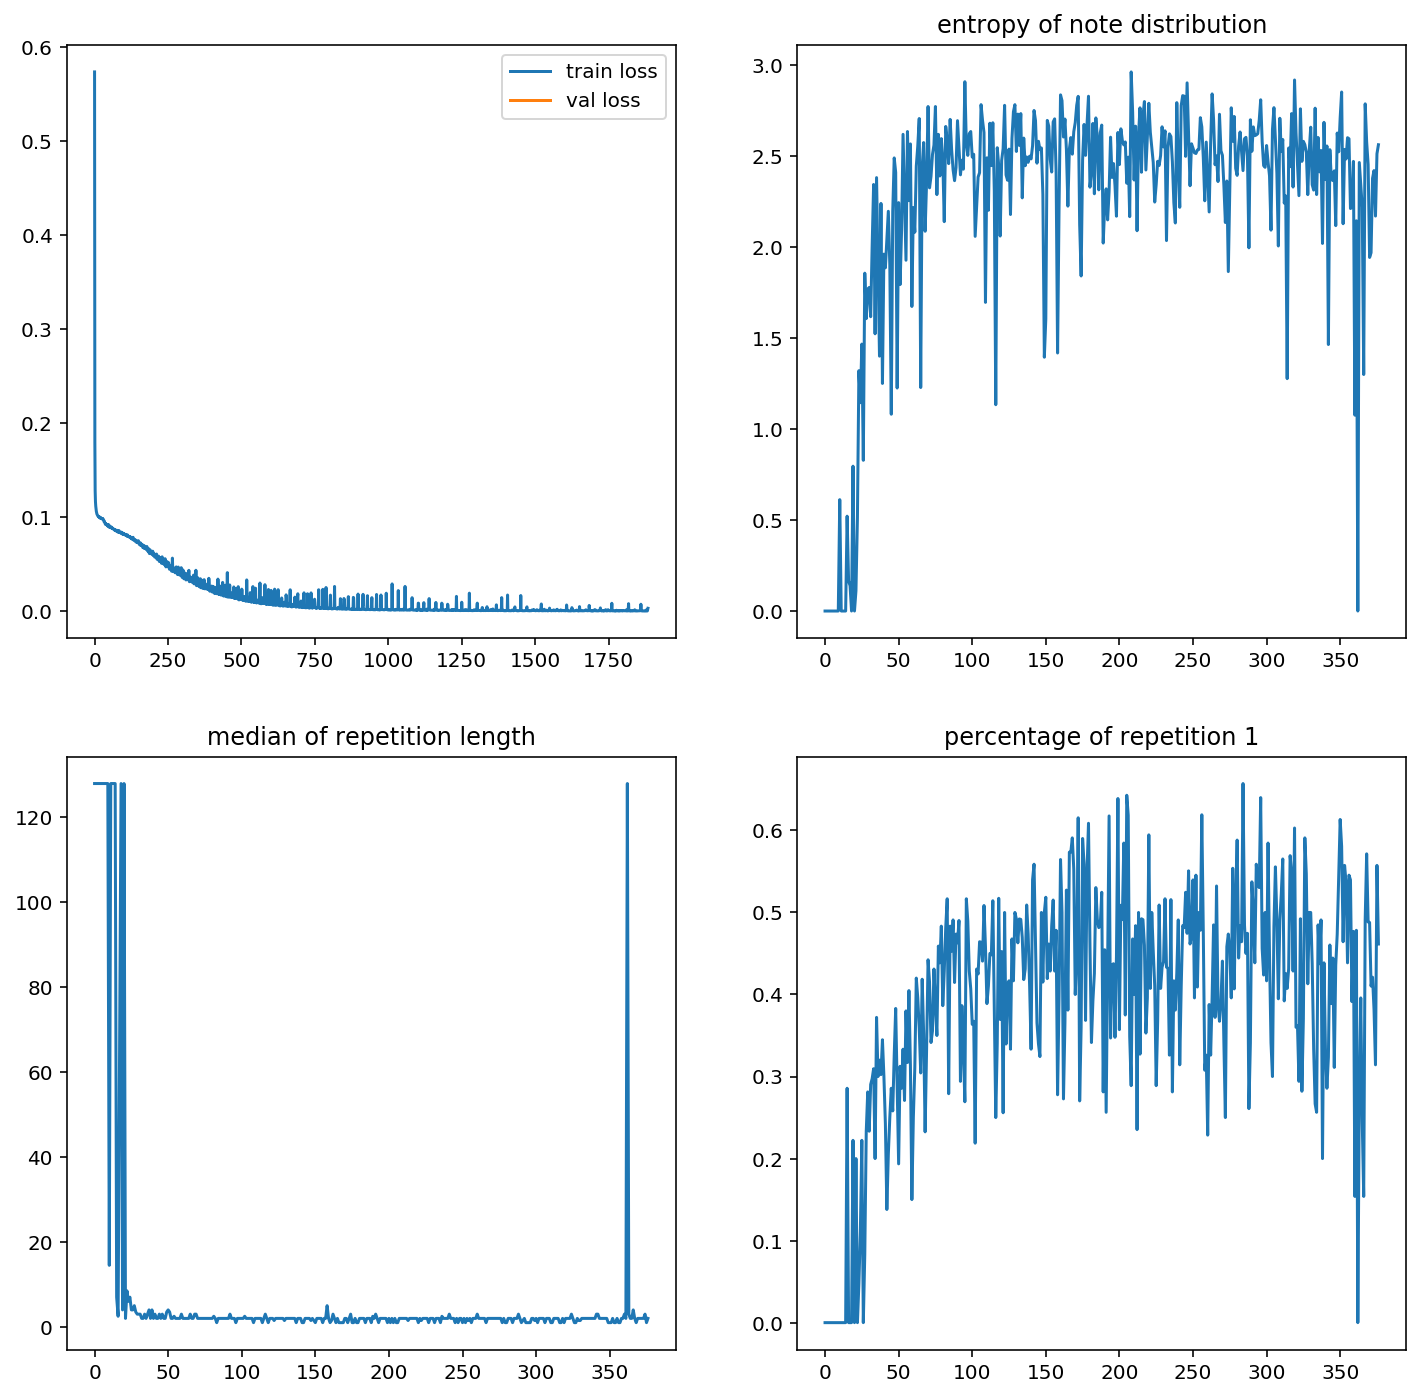

1312/1312 [==============================] - 1s - loss: 0.0033     
Epoch 1886/10000
1312/1312 [==============================] - 0s - loss: 7.1187e-04     
Epoch 1887/10000
1312/1312 [==============================] - 0s - loss: 5.9260e-04     
Epoch 1888/10000
1312/1312 [==============================] - 0s - loss: 3.7438e-04     
Epoch 1889/10000
1312/1312 [==============================] - 0s - loss: 4.9381e-04     
Epoch 1890/10000
 512/1312 [==========>...................] - ETA: 0s - loss: 5.8751e-04

KeyboardInterrupt: 

In [122]:
model.fit(nn_inout2[:-1,:,:], nn_inout2[1:,0,:], epochs=10000, batch_size=512, callbacks=[basicLossPlot])
# model.save_weights('weights-improvement-p3{datetime.now().strftime("%Y%m%d%H%M%S")}.hdf5')

seed size :  (1, 32, 144)
........................................................................................................................................................................................................Total size  (1, 232, 144)


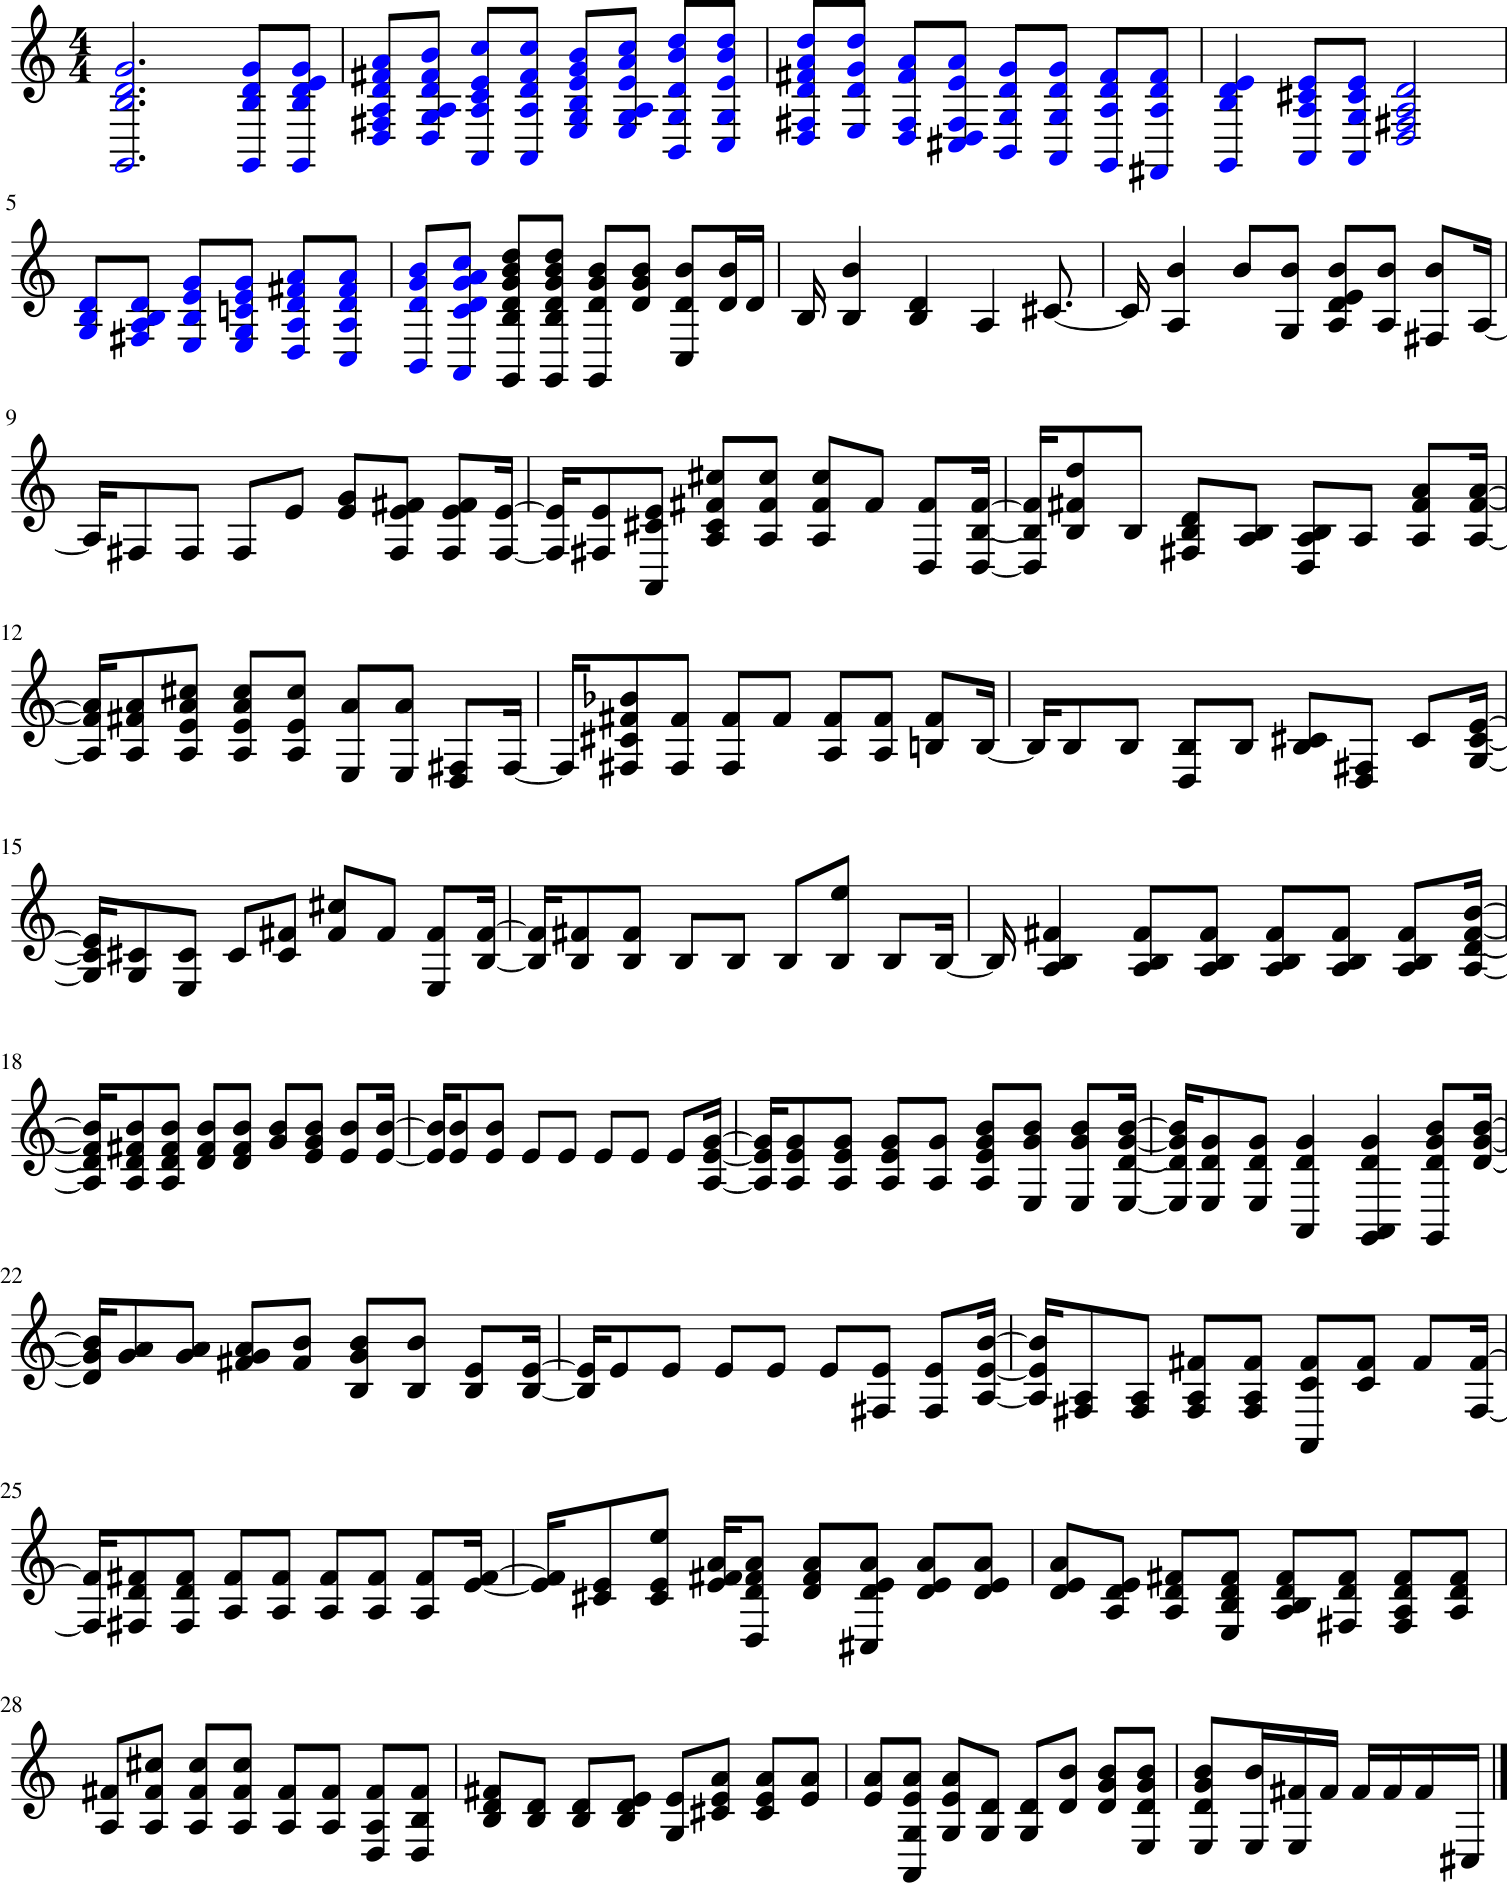

In [123]:
thresh = 0.7

# create a seed and predict stuff
t = random.randint(0,nn_inout2.shape[0]-1)
seed = nn_inout2[t:t+1,:,:]
print('seed size : ', seed.shape)

inp = seed
# inp.shape
# inp[:,-lookback:,:].shape
for i in range(200):
    p = model.predict(inp[:,-lookback:,:])

    p = cleanpred(p[0])
    inp = np.concatenate([inp,p[newaxis,newaxis,:]], axis=1)
    print('.', end='')
    
print('Total size ', inp.shape)    
s = stream.Stream()
for i in range(len(inp[0])):
    n = predbitfieldtonote(inp[0,i],threshold=thresh)
    if i < lookback:
        n.color='blue'
    s.append(n)
s.show()
# t1 = instrument.Organ()
# writePrediction(inp, instrument= t1)


In [124]:
t1 = instrument.Organ()
# t1 = instrument.SteelDrum()
# t1 = instrument.ElectricGuitar()
# t1 = instrument.ElectricBass()
# t1 = instrument.Percussion()
# t1 = instrument.Trumpet()
# t1 = instrument.Violin()
# t1 = instrument.Clarinet()
writePrediction(inp, instr= t1)

writing prediction size (1, 200, 144) to file output/test_output20180311110602.mid 


In [51]:
model.save_weights(f'spotify2{datetime.now().strftime("%Y%m%d%H%M%S")}.hdf5')

In [99]:
model.load_weights('spotify2{datetime.now().strftime("%Y%m%d%H%M%S")}.hdf5')

In [127]:
inp = Input(shape=(lookback,nn_inout.shape[1],))

x = Conv1D(128,10, strides=1, activation='relu', padding='same')(inp)

x = Dropout(0.3)(x)

x = Conv1D(128,2, strides=1, activation='relu', padding='same')(x)
x = Dropout(0.4)(x)

x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.3)(x)
x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = TimeDistributed(Dense(nn_inout.shape[1]))(x)
a1 = Activation('sigmoid')(Lambda(lambda z : z[:,:,:n_vocab])(x)) # notes
a2 = Activation('softmax')(Lambda(lambda z : z[:,:,n_vocab:])(x)) # duration
x= concatenate([a1,a2])
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
# model.compile(loss='kullback_leibler_divergence', optimizer='rmsprop')

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_32 (InputLayer)            (None, 32, 144)       0                                            
____________________________________________________________________________________________________
lstm_62 (LSTM)                   (None, 32, 256)       410624      input_32[0][0]                   
____________________________________________________________________________________________________
dropout_106 (Dropout)            (None, 32, 256)       0           lstm_62[0][0]                    
____________________________________________________________________________________________________
lstm_63 (LSTM)                   (None, 32, 512)       1574912     dropout_106[0][0]                
___________________________________________________________________________________________

In [128]:
# Add '0' at the end to make sure it fits blocks of 32
nn_inout2 = np.pad(nn_inout,((0,lookback-nn_inout.shape[0]%lookback),(0,0)), 'constant', constant_values=(0))
nn_inout2.shape
nn_inout2 = nn_inout2.reshape(-1, lookback, 144)
nn_inout2.shape
nn_inout2 = np.concatenate([nn_inout2[:-1,:,:], nn_inout2[1:, 0:1, :]],axis=1)

(42016, 144)

(1313, 32, 144)

In [ ]:
basicLossPlot = PlotLosses()

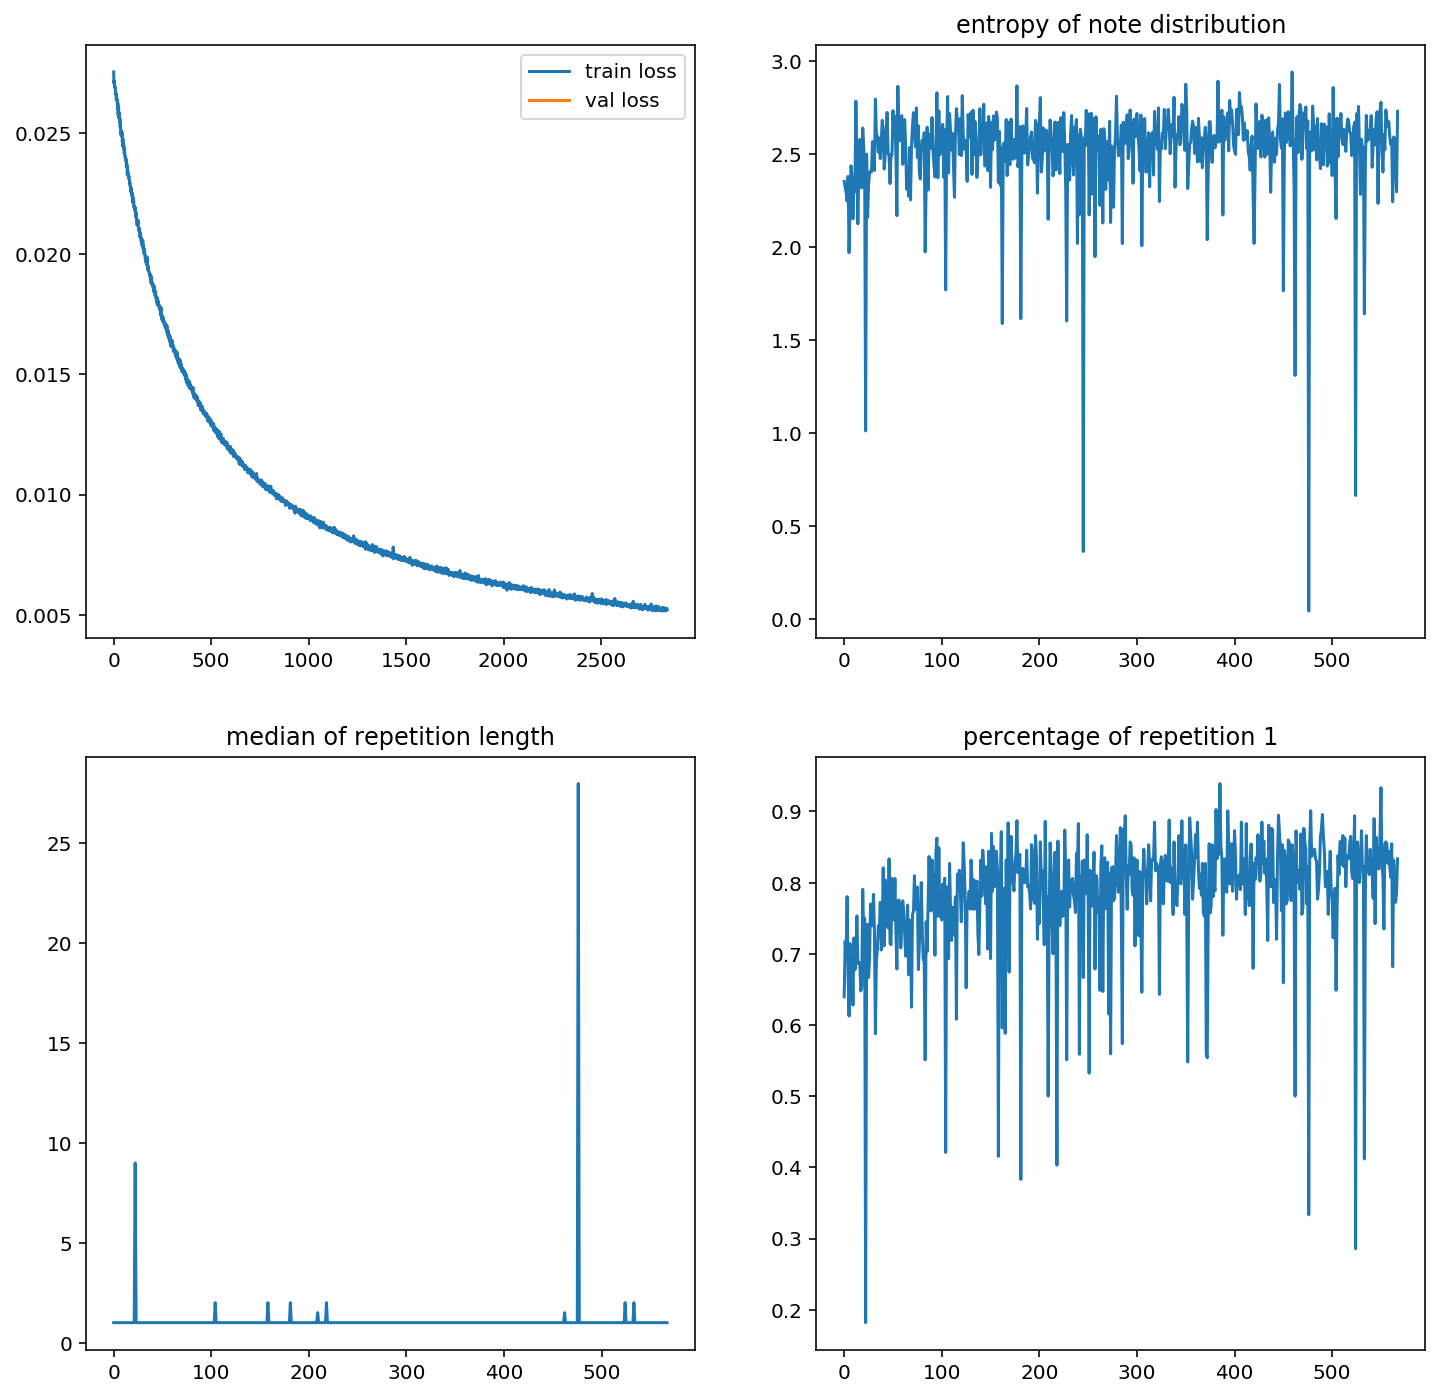

1311/1311 [==============================] - 4s - loss: 0.0052     
Epoch 1095/10000
1311/1311 [==============================] - 0s - loss: 0.0051     
Epoch 1096/10000
1311/1311 [==============================] - 0s - loss: 0.0051     
Epoch 1097/10000
1311/1311 [==============================] - 0s - loss: 0.0053     
Epoch 1098/10000
1311/1311 [==============================] - 0s - loss: 0.0053     
Epoch 1099/10000
1280/1311 [============================>.] - ETA: 0s - loss: 0.0052

KeyboardInterrupt: 

In [144]:
model.fit(nn_inout2[:-1,:32,:], nn_inout2[:-1,1:,:], epochs=10000, batch_size=256, callbacks=[basicLossPlot])

seed size :  (1, 33, 144)
................................................................................................................................Total size  (1, 161, 144)


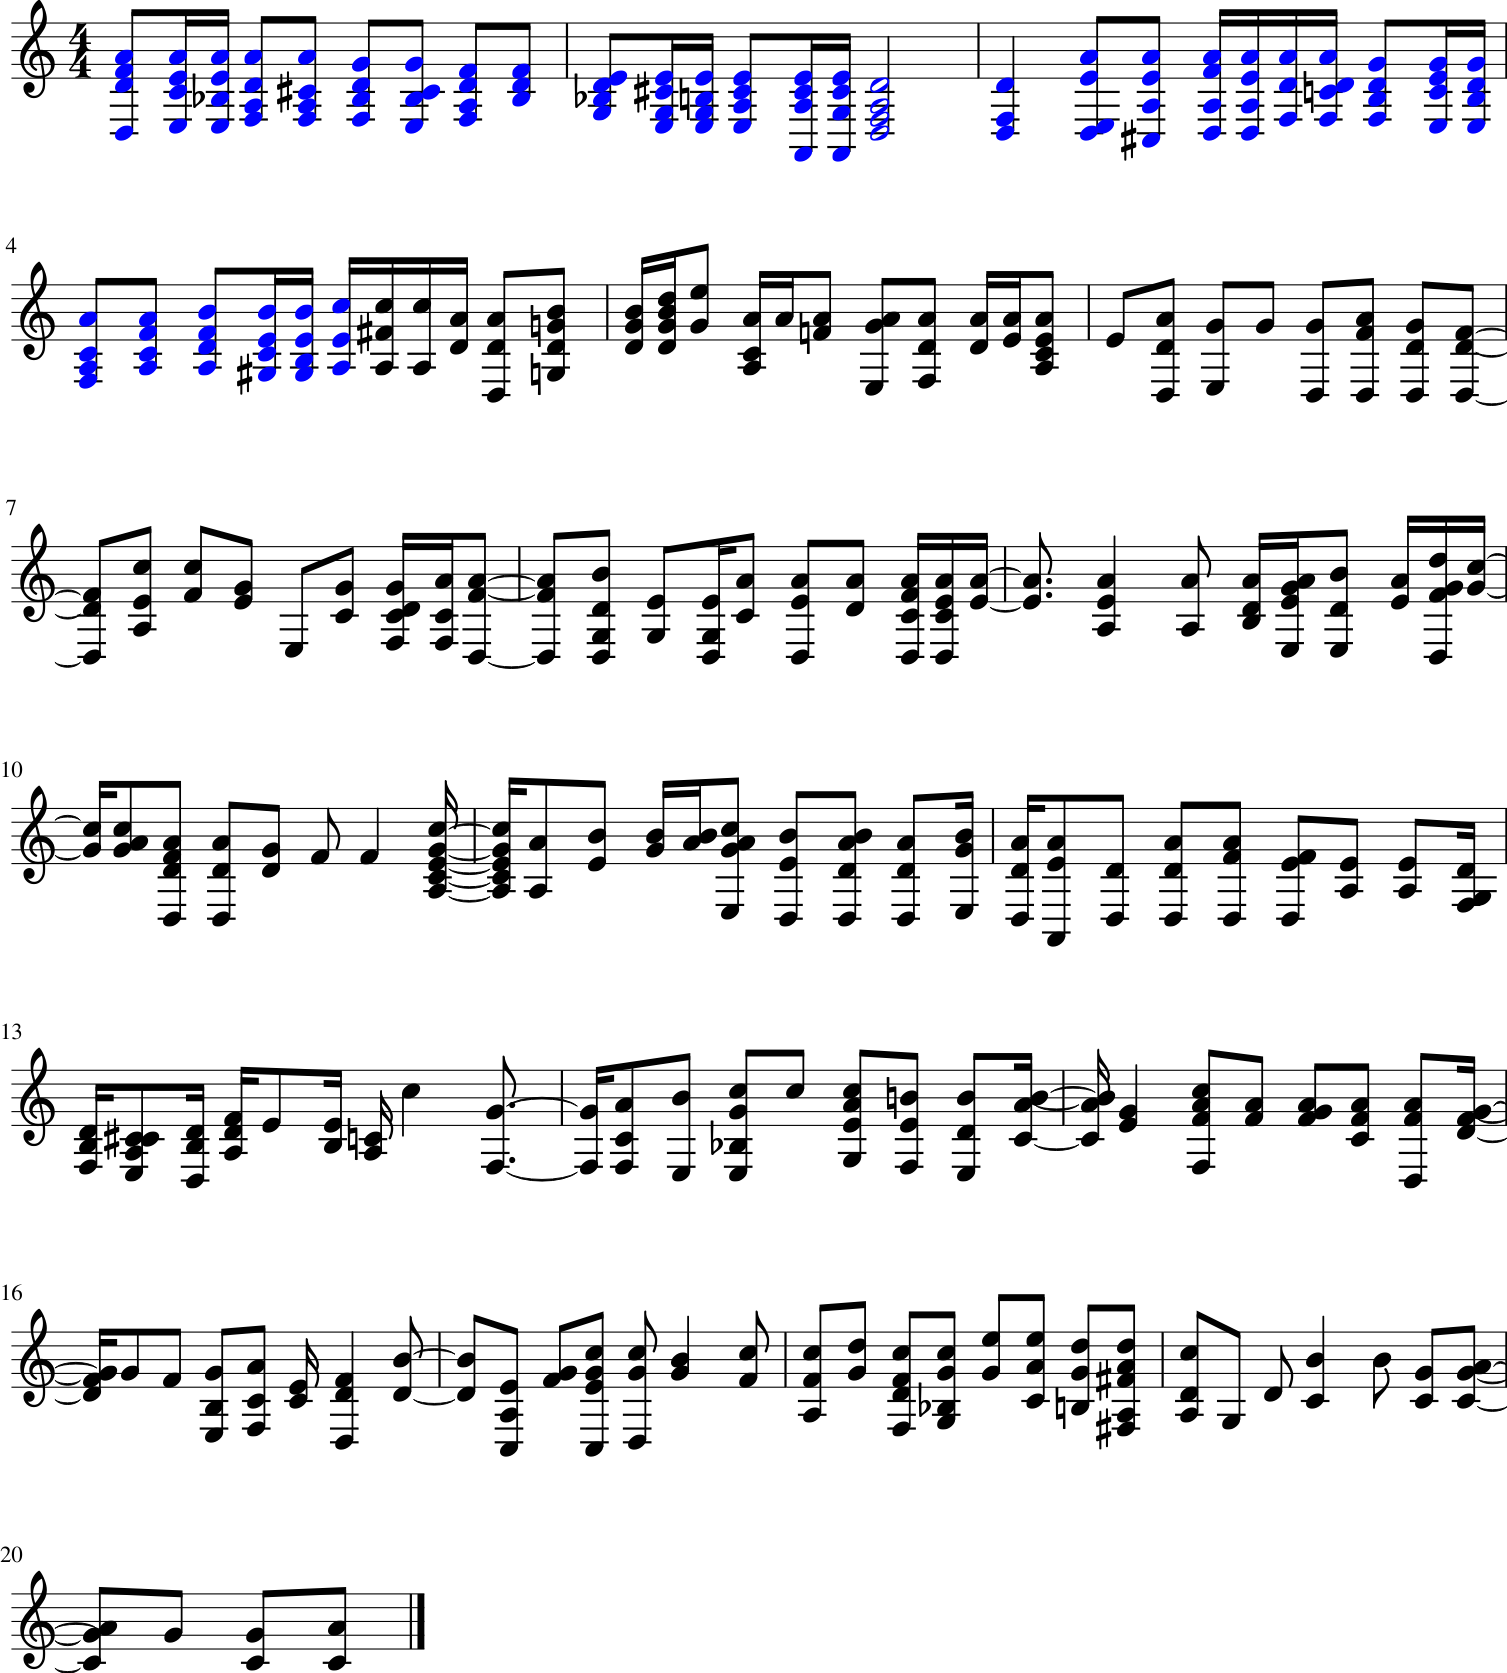

writing prediction size (1, 129, 144) to file output/test_output20180311124240.mid 


In [160]:
thresh = 0.8

# create a seed and predict stuff
t = random.randint(0,nn_inout2.shape[0]-1)
seed = nn_inout2[t:t+1,:,:]
print('seed size : ', seed.shape)

inp = seed
# inp.shape
# inp[:,-lookback:,:].shape
for i in range(128):
    p = model.predict(inp[:,-lookback:,:])

    p = cleanpred(p[0, -1])
    inp = np.concatenate([inp,p[newaxis,newaxis,:]], axis=1)
    print('.', end='')
    
print('Total size ', inp.shape)    
s = stream.Stream()
for i in range(len(inp[0])):
    n = predbitfieldtonote(inp[0,i],threshold=thresh)
    if i < lookback:
        n.color='blue'
    s.append(n)
s.show()


t1 = instrument.Organ()
writePrediction(inp, instr= t1)


In [156]:
t1 = instrument.Organ()
# t1 = instrument.Piano()
# t1 = instrument.SteelDrum()
# t1 = instrument.ElectricGuitar()
# t1 = instrument.ElectricBass()
# t1 = instrument.Percussion()
# t1 = instrument.Trumpet()
# t1 = instrument.Violin()
# t1 = instrument.Clarinet()
# t1 = instrument.Celesta()
writePrediction(inp, instr= t1)

writing prediction size (1, 129, 144) to file output/test_output20180311123229.mid 


In [139]:
model.save_weights(f'spotify3{datetime.now().strftime("%Y%m%d%H%M%S")}.hdf5')